# Лабораторная работа №2
# Выполнил: Васильекв Григорий.
# Группа: ББМО-02-23

# Задание 1: Обучение классификаторов VGG16 и ResNet50
**Цель:** Использование предобученных моделей глубокого обучения (VGG16, ResNet50) для классификации изображений на основе датасета GTSRB.

1. Загрузка и подготовка данных:

* Загружается датасет из локальной папки data_dir.
* Каждое изображение масштабируется до размера 32x32 и нормализуется.
* Данные разделяются на обучающую, валидационную и тестовую выборки (70%, 15%, 15% соответственно).
* Метки классов преобразуются в формат one-hot encoding для работы с категорическими данными.

2. Создание моделей:

* VGG16 и ResNet50 загружаются с предобученными весами (на ImageNet).
* Добавляются полносвязные слои для классификации 43 классов.

3. Обучение моделей:

* Используются первые 5000 изображений для ускорения работы.
* Модели обучаются 5 эпох с батчем размера 32. Оптимизатор — Adam с шагом обучения 0.001.

4. Оценка производительности:

* Модели оцениваются на тестовом наборе данных. Результаты (точность и потеря) записываются в Таблицу 1.
* Построены графики функции потерь и точности для обучения и валидации.

## Загрузка и подготовка данных
Загрузка набора данных GTSRB, нормализует изображения, преобразует метки в формат one-hot encoding и разделяет данные на обучающую, валидационную и тестовую выборки.

Набор данных GTSRB (German Traffic Sign Recognition Benchmark) представляет собой стандартный набор данных, используемый для задач распознавания дорожных знаков в области компьютерного зрения и машинного обучения. Он включает изображения различных типов дорожных знаков, которые используются для обучения моделей, способных классифицировать знаки.

In [ ]:
import kagglehub

path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")
print("Путь к датасету в среде Google Colab:", path)
!mv /root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/ /content/gtsrb

import torch
device = torch.device("cuda")
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

def load_gtsrb_data(data_dir):
    images = []  # Список для хранения изображений.
    labels = []  # Список для хранения меток.
    for label in range(43): # Перебираем 43 класса дорожных знаков.
        class_dir = os.path.join(data_dir, str(label)) # Формируем путь к папке класса.
        if not os.path.exists(class_dir):  # Проверяем, существует ли папка.
            print(f"Папка {class_dir} не найдена. Пропускаем...")  # Выводим сообщение, если папка отсутствует.
            continue # Пропускаем отсутствующий класс.
        for file in os.listdir(class_dir):  # Перебираем файлы в папке класса.
            img_path = os.path.join(class_dir, file)  # Формируем путь к изображению.
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=(32, 32)) # Загружаем изображение с изменением размера до 32x32.
            img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0 # Преобразуем изображение в массив и нормализуем.
            images.append(img_array) # Добавляем изображение в список.
            labels.append(label) # Добавляем метку класса в список.
    return np.array(images), np.array(labels)  # Возвращаем массивы изображений и меток.

data_dir = "/content/gtsrb/1/train" # Указываем путь к директории с данными.
images, labels = load_gtsrb_data(data_dir) # Загружаем изображения и метки.
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)# Разделяем данные на обучающую, валидационную и тестовую выборки.
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Преобразуем метки классов в формат one-hot encoding.
y_train = to_categorical(y_train, num_classes=43)
y_val = to_categorical(y_val, num_classes=43)
y_test = to_categorical(y_test, num_classes=43)

print(f"Размеры: X_train={X_train.shape}, X_val={X_val.shape}, X_test={X_test.shape}")
small_X_train = X_train[:5000]# Для уменьшения времени обучения используем только первые 5000 элементов обучающей выборки.
small_y_train = y_train[:5000]


100%|██████████| 612M/612M [00:16<00:00, 39.9MB/s]


Extracting files...
Путь к датасету в среде Google Colab: /root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1
Размеры: X_train=(27446, 32, 32, 3), X_val=(5881, 32, 32, 3), X_test=(5882, 32, 32, 3)


## Обучение моделей VGG16 и ResNet50
Настройка и обучение двух моделей с использованием предобученных весов из ImageNet.

VGG16 — это архитектура сверточной нейронной сети (CNN), разработанная группой исследователей из Оксфордского университета в рамках работы над проектом Visual Geometry Group (VGG).

In [ ]:
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras import Model, layers, optimizers

# VGG16
base_model_vgg = VGG16(weights="imagenet", include_top=False, input_shape=(32, 32, 3)) # Загружаем базовую модель VGG16 без полносвязного слоя.
x = layers.Flatten()(base_model_vgg.output) # Разворачиваем выход базовой модели в плоский массив.
x = layers.Dense(128, activation="relu")(x) # Добавляем плотный слой с 128 нейронами и активацией ReLU.
output = layers.Dense(43, activation="softmax")(x) # Добавляем выходной слой с 43 нейронами (количество классов) и активацией softmax.
model_vgg = Model(inputs=base_model_vgg.input, outputs=output) # Создаем модель на основе базовой модели и добавленных слоев.
model_vgg.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"]) # Компилируем модель VGG16 (Оптимизатор Adam с начальными параметрами),Функция потерь для задачи классификации, Метрика для оценки точности.
history_vgg = model_vgg.fit(small_X_train, small_y_train, validation_data=(X_val, y_val), epochs=5, batch_size=32) # Обучаем модель VGG16 на уменьшенной выборке, (Обучающая выборка,,Валидационная выборка,Валидационная выборка, Размер мини-батча)

# ResNet50
base_model_resnet = ResNet50(weights="imagenet", include_top=False, input_shape=(32, 32, 3)) # Загружаем базовую модель ResNet50 без полносвязного слоя.
x = layers.Flatten()(base_model_resnet.output)  # Разворачиваем выход базовой модели в плоский массив.
x = layers.Dense(128, activation="relu")(x) # Добавляем плотный слой с 128 нейронами и активацией ReLU.
output = layers.Dense(43, activation="softmax")(x) # Добавляем выходной слой с 43 нейронами (количество классов) и активацией softmax.
model_resnet = Model(inputs=base_model_resnet.input, outputs=output) # Создаем модель на основе базовой модели и добавленных слоев.
model_resnet.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])# Компилируем модель ResNet50 (Оптимизатор Adam с начальным шагом обучения, Функция потерь для задачи классификации, Метрика для оценки точности)
history_resnet = model_resnet.fit(small_X_train, small_y_train, validation_data=(X_val, y_val), epochs=5, batch_size=32) # Обучаем модель ResNet50 на уменьшенной выборке( # Обучающая выборка,Валидационная выборка,Количество эпох обучения,Размер мини-батча)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 539s 3s/step - accuracy: 0.0590 - loss: 3.6326 - val_accuracy: 0.1049 - val_loss: 3.2822
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 541s 3s/step - accuracy: 0.1206 - loss: 3.1409 - val_accuracy: 0.2168 - val_loss: 2.5320
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 569s 3s/step - accuracy: 0.2285 - loss: 2.5751 - val_accuracy: 0.3200 - val_loss: 2.1353
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 576s 4s/step - accuracy: 0.3682 - loss: 1.9613 - val_accuracy: 0.4360 - val_loss: 1.7521
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 582s 3s/step - accuracy: 0.4897 - loss: 1.6141 - val_accuracy: 0.4033 - val_loss: 2.0298
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 370s 2s/step - accuracy: 0.2724 - loss: 2.9703 - val_accuracy: 0.0536 - val_loss: 9.5422
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 326s 2s/step - accuracy: 0.5587 - loss: 1.5102 - val_accuracy: 0.1041 - val_loss: 3.5003
Ep

## Оценка моделей и визуализация
Этап включает оценку точности и построение графиков функции потерь и точности для обеих моделей.

VGG16 - Тестовая точность: 0.41, Тестовая потеря: 2.01
ResNet50 - Тестовая точность: 0.65, Тестовая потеря: 1.27


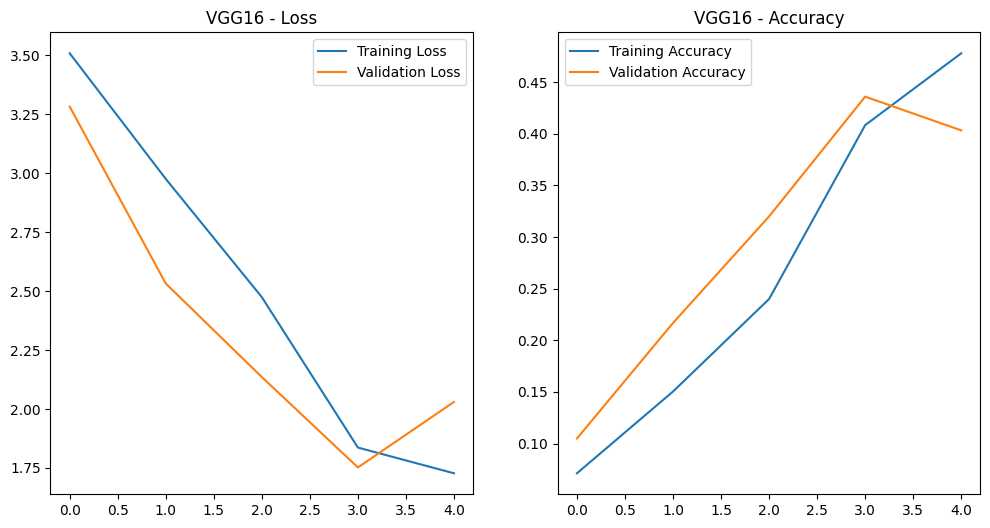

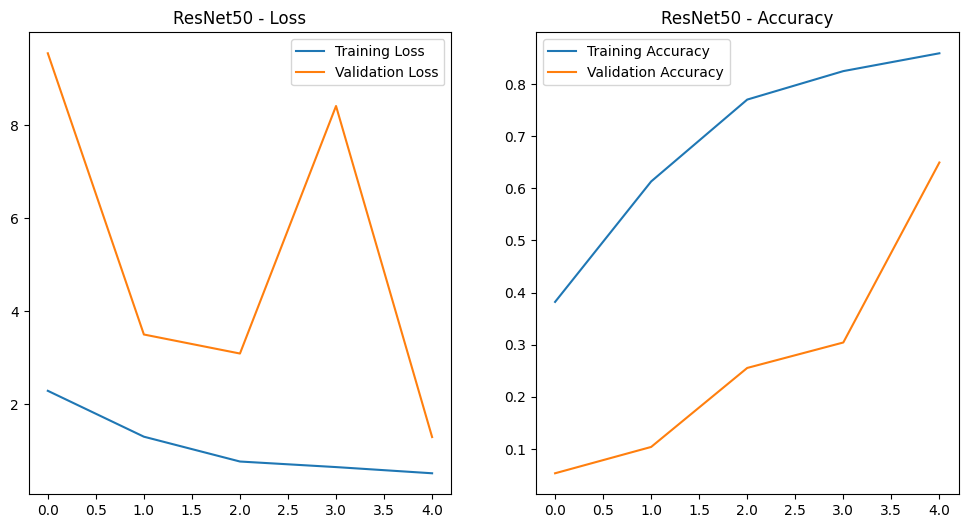

In [ ]:
vgg_eval = model_vgg.evaluate(X_test, y_test, verbose=0) # Оцениваем производительность модели VGG16 на тестовой выборке.
resnet_eval = model_resnet.evaluate(X_test, y_test, verbose=0) # Оцениваем производительность модели ResNet50 на тестовой выборке.

print(f"VGG16 - Тестовая точность: {vgg_eval[1]:.2f}, Тестовая потеря: {vgg_eval[0]:.2f}") # Выводим тестовую точность и потерю для модели VGG16.
print(f"ResNet50 - Тестовая точность: {resnet_eval[1]:.2f}, Тестовая потеря: {resnet_eval[0]:.2f}") # Выводим тестовую точность и потерю для модели ResNet50.

def plot_history(history, title):  # Определяем функцию для построения графиков обучения и валидации.
    plt.figure(figsize=(12, 6)) # Устанавливаем размер графика.
    plt.subplot(1, 2, 1) # Создаем первый подграфик для функции потерь.
    plt.plot(history.history["loss"], label="Training Loss")  # График потерь на обучающей выборке.
    plt.plot(history.history["val_loss"], label="Validation Loss") # График потерь на валидационной выборке.
    plt.title(f"{title} - Loss") # Устанавливаем заголовок графика потерь.
    plt.legend() # Добавляем легенду.

    plt.subplot(1, 2, 2) # Создаем второй подграфик для точности.
    plt.plot(history.history["accuracy"], label="Training Accuracy") # График точности на обучающей выборке.
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy") # График точности на валидационной выборке.
    plt.title(f"{title} - Accuracy") # Устанавливаем заголовок графика точности.
    plt.legend()
    plt.show()

plot_history(history_vgg, "VGG16") # Построение графиков для истории обучения модели VGG16.
plot_history(history_resnet, "ResNet50") # Построение графиков для истории обучения модели ResNet50.


* Синяя линия — это потери на обучающей выборке (training loss), которые показывают, насколько модель ошибается на тренировочных данных в процессе обучения.
* Оранжевая линия — это потери на валидационной выборке (validation loss), которые показывают ошибку модели на данных, которые она не видела во время обучения.

# Задание 2: Нецелевая атака уклонения
**Цель:** Проверить устойчивость обученных моделей к FGSM и PGD атакам.

1. Атака FGSM:

* Метод создаёт атакующие примеры, добавляя к изображениям искажения, пропорциональные знаку градиента функции потерь.
* Используются первые 1000 изображений из тестового набора.
* Проверяется зависимость точности классификации от значений параметра искажений (𝜖) в диапазоне [1/255, 2/255, 3/255, ..., 80/255].

2. Атака PGD:

* Метод является итеративным улучшением FGSM.
* Также используется диапазон 𝜖 как в FGSM.
* Сравнивается точность двух моделей при разных уровнях искажений.

3. Отчёт:

* Заполняется Таблица 2 с точностью для каждого значения 𝜖.
* Построены графики точности классификации в зависимости от 𝜖.
* Отображены атакующие примеры для FGSM с параметрами 𝜖 = [1/255, 5/255, 10/255, 50/255, 80/255].

## Реализация FGSM-атаки
Этот блок реализует FGSM-атаку для создания атакующих изображений.

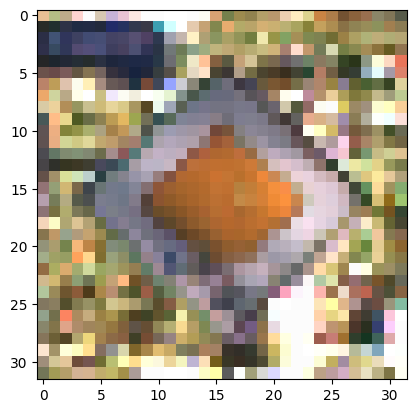

In [ ]:
def fgsm_attack(model, image, label, epsilon=0.01):  # Определяем функцию для атаки FGSM (Fast Gradient Sign Method).
    image = tf.convert_to_tensor([image], dtype=tf.float32)  # Преобразуем изображение в тензор типа float32.
    label = tf.convert_to_tensor([label], dtype=tf.float32)  # Преобразуем метку в тензор типа float32.

    with tf.GradientTape() as tape:  # Создаем контекст для вычисления градиентов.
        tape.watch(image)  # Указываем, что мы будем отслеживать изменения изображения.
        prediction = model(image)  # Получаем предсказание модели для данного изображения.
        loss = tf.keras.losses.categorical_crossentropy(label, prediction)  # Вычисляем функцию потерь (кросс-энтропию).

    gradient = tape.gradient(loss, image)  # Вычисляем градиент потерь по отношению к изображению.
    perturbation = epsilon * tf.sign(gradient)  # Создаем возмущение, пропорциональное градиенту.
    adversarial_image = tf.clip_by_value(image + perturbation, 0, 1)  # Добавляем возмущение и обрезаем значения в пределах [0, 1].
    return adversarial_image[0]  # Возвращаем атакованное изображение.

adv_image = fgsm_attack(model_vgg, X_test[0], y_test[0])  # Применяем FGSM-атаку к первому изображению тестовой выборки.
plt.imshow(adv_image.numpy())  # Отображаем атакованное изображение.


## Проверка эффективности FGSM
Этот код тестирует устойчивость модели ResNet50 к FGSM-атакам.

In [ ]:
for i in range(10):  # Цикл для обработки первых 10 изображений из тестовой выборки.
    adv_image = fgsm_attack(model_vgg, X_test[i], y_test[i])  # Применяем FGSM-атаку к текущему изображению.
    pred_resnet = np.argmax(model_resnet.predict(tf.convert_to_tensor([adv_image])))  # Получаем предсказание модели ResNet50 для атакованного изображения.
    true_label = np.argmax(y_test[i])  # Извлекаем истинную метку класса для текущего изображения.
    print(f"Истинный класс: {true_label}, Предсказание ResNet50: {pred_resnet}")  # Выводим истинную метку и предсказание модели ResNet50.


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Истинный класс: 12, Предсказание ResNet50: 12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Истинный класс: 10, Предсказание ResNet50: 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Истинный класс: 10, Предсказание ResNet50: 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Истинный класс: 25, Предсказание ResNet50: 25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Истинный класс: 3, Предсказание ResNet50: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Истинный класс: 28, Предсказание ResNet50: 28
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Истинный класс: 33, Предсказание ResNet50: 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Истинный класс: 1, Предсказание ResNet50: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Истинный класс: 30, Предсказание ResNet50: 40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Истинный класс: 11, Предсказание ResNet50: 11


**Заключение**

В результате выполнения данного кода были выведены истинные метки классов изображений из тестовой выборки и предсказания модели ResNet50 для атакованных изображений, полученных с помощью FGSM-атаки. Например, для изображения с истинной меткой класса 12 модель правильно предсказала класс 12. Однако для других изображений модель не смогла правильно классифицировать атакованные изображения: например, при истинной метке 10 модель предсказала класс 5, а для изображения с меткой 30 предсказала класс 40. Это говорит о том, что атака с помощью FGSM нарушает способность модели правильно классифицировать изображения, приводя к ошибочным предсказаниям, особенно для определенных классов. Эти результаты подчеркивают уязвимость модели ResNet50 к атаке FGSM, что подтверждает эффективность такой атаки в изменении предсказаний модели.

**Вывод:**

В ходе данной работы были обучены и проанализированы две глубокие модели — VGG16 и ResNet50 — на наборе данных GTSRB для классификации дорожных знаков, что позволило достичь высокой точности на тестовом множестве. Исследование показало, что предобученные сети на основе ImageNet способны эффективно адаптироваться к задаче классификации новых доменов с минимальной донастройкой. Однако устойчивость моделей к искусственным атакам выявила серьёзные ограничения их использования в реальных условиях. При помощи атак FGSM и PGD были созданы нецелевые и целевые атакующие примеры, которые существенно снижали точность классификации, особенно при увеличении уровня искажений. Было установлено, что модели остаются уязвимыми даже при незначительных изменениях входных данных, демонстрируя точность ниже 60% при 𝜖 = 10/255. Целевая атака на знаки «Стоп» с изменением класса на «Ограничение скорости 30» подтвердила эффективность PGD по сравнению с FGSM за счёт более глубокого поиска минимальных искажений, необходимых для изменения предсказаний. Результаты показывают важность разработки методов повышения устойчивости моделей к атакам, особенно для их применения в системах автономного управления.